In [14]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import holidays
from sklearn.model_selection import RandomizedSearchCV


In [15]:
df = pd.read_csv("Births2015.csv")
df = df.drop(columns = ['Unnamed: 0', 'wday'], axis = 1)
df['date'] = pd.to_datetime(df['date'])
df.describe()
df = df.set_index('date')

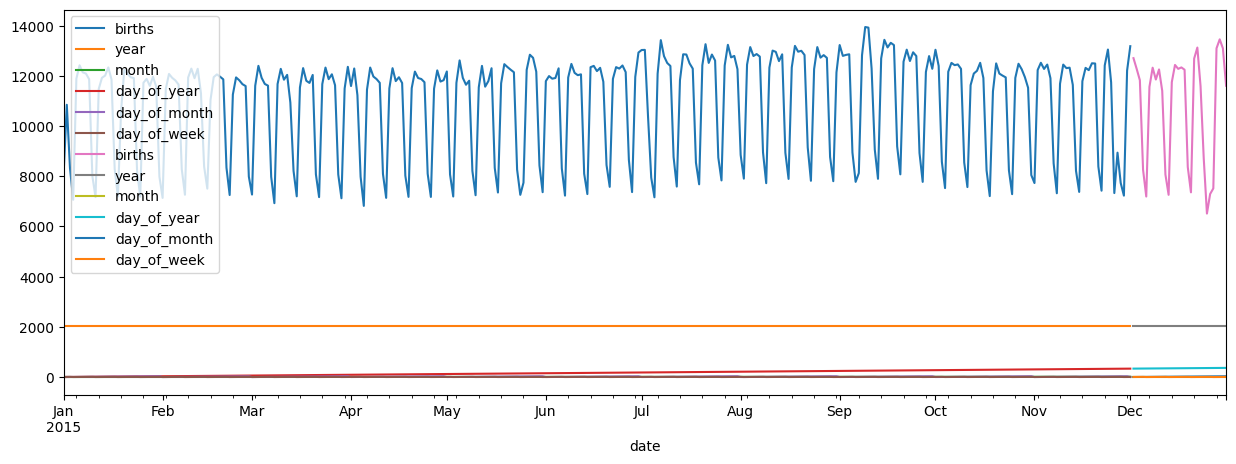

In [16]:
train = df[:335]
test = df[335:]
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label ='Training Set')
test.plot(ax=ax, label ='Test Set')
plt.show()

In [17]:
# Function to check if a date is a US holiday
def is_us_holiday(date):
    us_holidays = holidays.US(years=date.year)
    return date in us_holidays



def create_features(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df.index.day / 30)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df.index.day / 30)
    # Add 'month_sin' and 'month_cos' columns to DataFrame
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 11)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 11)
    #df['quarter_of_year'] = df.index.quarter
    #df['week_of_year'] = df.index.isocalendar().week.astype('int32')
    #df["is_wknd"] = df.index.weekday // 4
    #df['is_month_start'] = df.index.is_month_start.astype(int)
    #df['is_month_end'] = df.index.is_month_end.astype(int)
    #df['season'] = df['month'] % 12 // 3 + 1
    df['lag7_births'] = df['births'].shift(periods=7)
    df['lag14_births'] = df['births'].shift(periods=14)
    df['lag4_births'] = df['births'].shift(periods=4)
    df['lag6_births'] = df['births'].shift(periods=6)
    df['births_diff7'] = df['births'].shift(7) - df['births'].shift(14)
    window_size = 7
    # Calculate the rolling mean, max, and min for the relevant columns
    #df['rolling_mean7'] = df['lag7_births'].rolling(window=window_size, min_periods=1, closed= "left").mean()
    #df['rolling_max7'] = df['lag7_births'].rolling(window=window_size, min_periods=1, closed= "left").max()
    #df['rolling_min7'] = df['lag7_births'].rolling(window=window_size, min_periods=1, closed= "left").min()
    df['rolling_mean'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").mean()
    df['rolling_max'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").max()
    df['rolling_min'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").min()
    # Add 'is_us_holiday' column to DataFrame
    df['is_us_holiday'] = df.index.map(is_us_holiday).astype(int)
    return df


In [18]:
df = create_features(df)

In [19]:
train = create_features(train)
test= create_features(test)

In [20]:
df.columns

Index(['births', 'year', 'month', 'day_of_year', 'day_of_month', 'day_of_week',
       'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'month_sin', 'month_cos', 'lag7_births',
       'lag14_births', 'lag4_births', 'lag6_births', 'births_diff7',
       'rolling_mean', 'rolling_max', 'rolling_min', 'is_us_holiday'],
      dtype='object')

In [21]:
FEATURES= [ 'month', 'day_of_year', 'day_of_month', 'day_of_week',
        'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'month_sin', 'month_cos', 'lag7_births',
       'lag14_births', 'lag4_births', 'lag6_births', 'births_diff7',
       'rolling_max', 'rolling_min', 'is_us_holiday', 'rolling_mean']
TARGET = 'births'

In [22]:
train = train.dropna()
test= test.dropna()

In [23]:
X_train = train[FEATURES]
y_train = train[TARGET]


In [24]:
X_test = test[FEATURES]
y_test = test[TARGET]

In [25]:
reg = xgb.XGBRegressor(n_estimators= 1000, early_stopping_rounds= 50)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)


[0]	validation_0-rmse:7827.46040	validation_1-rmse:7776.34746
[1]	validation_0-rmse:5518.01183	validation_1-rmse:5496.88449
[2]	validation_0-rmse:3902.36213	validation_1-rmse:3987.33948
[3]	validation_0-rmse:2765.49803	validation_1-rmse:2985.55406
[4]	validation_0-rmse:1967.09366	validation_1-rmse:2436.25109
[5]	validation_0-rmse:1410.18207	validation_1-rmse:2090.70398
[6]	validation_0-rmse:1024.78354	validation_1-rmse:1925.18393
[7]	validation_0-rmse:753.99016	validation_1-rmse:1827.62164
[8]	validation_0-rmse:563.91582	validation_1-rmse:1740.10870
[9]	validation_0-rmse:432.55606	validation_1-rmse:1707.99883
[10]	validation_0-rmse:337.30072	validation_1-rmse:1631.96639
[11]	validation_0-rmse:273.21986	validation_1-rmse:1583.97537
[12]	validation_0-rmse:229.69007	validation_1-rmse:1543.41476
[13]	validation_0-rmse:197.79058	validation_1-rmse:1510.54037
[14]	validation_0-rmse:178.15898	validation_1-rmse:1463.08602
[15]	validation_0-rmse:161.22329	validation_1-rmse:1459.03353
[16]	valida

[59]	validation_0-rmse:9.65601	validation_1-rmse:1421.00982
[60]	validation_0-rmse:9.16783	validation_1-rmse:1421.13848
[61]	validation_0-rmse:8.23988	validation_1-rmse:1420.57986
[62]	validation_0-rmse:7.70555	validation_1-rmse:1420.57068
[63]	validation_0-rmse:7.43203	validation_1-rmse:1421.15589
[64]	validation_0-rmse:6.94456	validation_1-rmse:1421.05657
[65]	validation_0-rmse:6.60186	validation_1-rmse:1421.37166
[66]	validation_0-rmse:6.13470	validation_1-rmse:1421.57611
[67]	validation_0-rmse:5.79431	validation_1-rmse:1421.65391
[68]	validation_0-rmse:5.35466	validation_1-rmse:1421.43478
[69]	validation_0-rmse:5.15625	validation_1-rmse:1421.20002
[70]	validation_0-rmse:4.91333	validation_1-rmse:1421.06508
[71]	validation_0-rmse:4.55566	validation_1-rmse:1421.25660
[72]	validation_0-rmse:4.39975	validation_1-rmse:1421.28486
[73]	validation_0-rmse:4.19578	validation_1-rmse:1421.38618
[74]	validation_0-rmse:3.98046	validation_1-rmse:1421.36836


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [26]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)

In [27]:
import plotly.graph_objects as go

# Assuming you have the DataFrame df with 'births' and 'prediction' columns

# Create the figure object
fig = go.Figure()

# Add the 'births' trace to the figure
fig.add_trace(go.Scatter(x=df.index, y=df['births'], mode='lines', name='Truth Data'))

# Add the 'prediction' trace to the figure
fig.add_trace(go.Scatter(x=df.index, y=df['prediction'], mode='lines', name='Predictions'))

# Update the layout of the figure
fig.update_layout(title='RAW DATA AND PREDICTION',
                  xaxis_title='Date',
                  yaxis_title='Births',
                  showlegend=True,
                  legend_title_text='Legend')

# Show the plot
fig.show()


In [28]:
score = np.sqrt(mean_squared_error(test['births'], test['prediction']))
print(f'RMSE: {score:0.2f}')

RMSE: 1411.60
